In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import requests
import tarfile
import zipfile
import scipy.io
from scipy.ndimage import gaussian_filter, convolve
def extract_zip(zip_path, extract_to):
    if not os.path.exists(extract_to):
        print("Extracting dataset...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("Extraction complete.")
    else:
        print("Dataset already extracted.")

dataset_zip = "archive.zip"
dataset_folder = "BSDS500"
extract_zip(dataset_zip, dataset_folder)

Extracting dataset...
Extraction complete.


Epoch 1/50, Train Loss: 0.0239, Val Loss: 0.0220
Epoch 2/50, Train Loss: 0.0216, Val Loss: 0.0206
Epoch 3/50, Train Loss: 0.0204, Val Loss: 0.0197
Epoch 4/50, Train Loss: 0.0196, Val Loss: 0.0192
Epoch 5/50, Train Loss: 0.0191, Val Loss: 0.0189
Epoch 6/50, Train Loss: 0.0188, Val Loss: 0.0187
Epoch 7/50, Train Loss: 0.0185, Val Loss: 0.0185
Epoch 8/50, Train Loss: 0.0183, Val Loss: 0.0184
Epoch 9/50, Train Loss: 0.0181, Val Loss: 0.0184
Epoch 10/50, Train Loss: 0.0180, Val Loss: 0.0182
Epoch 11/50, Train Loss: 0.0179, Val Loss: 0.0182
Epoch 12/50, Train Loss: 0.0177, Val Loss: 0.0180
Epoch 13/50, Train Loss: 0.0176, Val Loss: 0.0180
Epoch 14/50, Train Loss: 0.0176, Val Loss: 0.0181
Epoch 15/50, Train Loss: 0.0175, Val Loss: 0.0179
Epoch 16/50, Train Loss: 0.0174, Val Loss: 0.0179
Epoch 17/50, Train Loss: 0.0174, Val Loss: 0.0178
Epoch 18/50, Train Loss: 0.0173, Val Loss: 0.0178
Epoch 19/50, Train Loss: 0.0173, Val Loss: 0.0179
Epoch 20/50, Train Loss: 0.0172, Val Loss: 0.0178
Epoch 21/

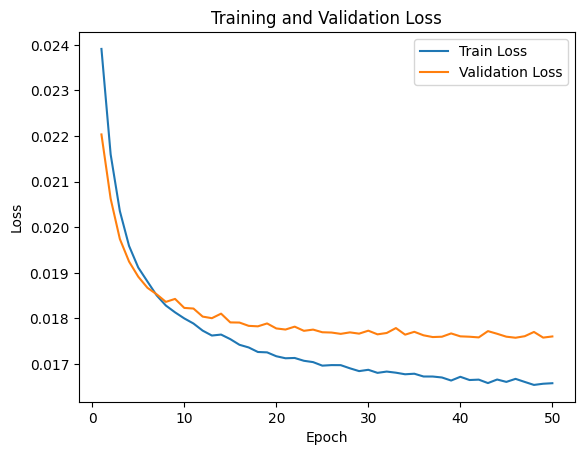

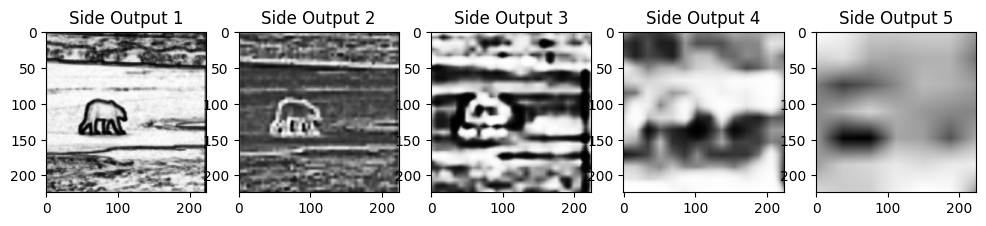

Learned Fusion Weights: [[[[-0.57745385]]

  [[ 0.4708028 ]]

  [[ 0.19771624]]

  [[-0.367891  ]]

  [[-0.32948852]]]]


TypeError: Invalid shape (3, 224, 224) for image data

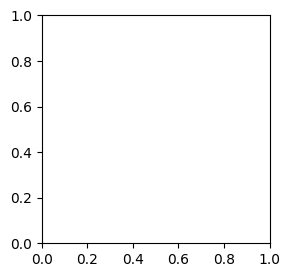

In [ ]:
# Set device for PyTorch
device = torch.device("cpu")

#Load dataset.
class BSDataset(Dataset):
    def __init__(self, image_dir, gt_dir, transform=None):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.gt_paths = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir) if f.endswith('.mat')])
        self.transform = transform

    def load_mat_image(self, mat_path):
        mat_data = scipy.io.loadmat(mat_path)
        if 'groundTruth' in mat_data:
            gt_list = mat_data['groundTruth'][0]
            gt_sum = sum(gt['Boundaries'][0, 0] for gt in gt_list)
            gt_avg = gt_sum / len(gt_list)
            return gt_avg
        raise ValueError("Invalid .mat file structure.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      image = Image.open(self.image_paths[idx]).convert("L")  # Grayscale image
      label = self.load_mat_image(self.gt_paths[idx])
      resize = transforms.Resize((224, 224))
      image = resize(image)
      label = Image.fromarray((label * 255).astype(np.uint8))
      label = resize(label)
      # Convert grayscale image to 3 channels by replicating the channel
      image = image.convert("RGB")
      if self.transform:
        image = self.transform(image)
        label = transforms.ToTensor()(label)
      return image, label


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = BSDataset("BSDS500/images/train", "BSDS500/ground_truth/train", transform)
val_dataset = BSDataset("BSDS500/images/val", "BSDS500/ground_truth/val", transform)
test_dataset = BSDataset("BSDS500/images/test", "BSDS500/ground_truth/test", transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Defining HED-Based Model
class HED(nn.Module):
    def __init__(self):
        super(HED, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.vgg = vgg16.features[:31]  # Extracting layers up to last conv
        for param in self.vgg.parameters():
            param.requires_grad = False # freezing the vgg16 parameters
        self.side_outputs = nn.ModuleList([
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Conv2d(128, 1, kernel_size=1),
            nn.Conv2d(256, 1, kernel_size=1),
            nn.Conv2d(512, 1, kernel_size=1),
            nn.Conv2d(512, 1, kernel_size=1)
        ])

        self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=True)
        self.weighted_fusion = nn.Conv2d(5, 1, kernel_size=1)# weighted average of side outputs
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        features = []
        for layer in self.vgg:
            x = layer(x)
            if isinstance(layer, nn.MaxPool2d):
                features.append(x)# finding the maxpool layers to extract side outputs
        side_outs = [self.upsample(side(x)) for side, x in zip(self.side_outputs, features)]
        fused = self.weighted_fusion(torch.cat(side_outs, dim=1))
        return [self.sigmoid(out) for out in side_outs] + [self.sigmoid(fused)]

model = HED().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


#Loss Function(weighted)
def class_balanced_loss(side_pred, target):
    target = target.float().to(device)
    side_pred = side_pred.to(device)
    count_pos = torch.sum(target) #Y+
    count_neg = target.numel() - count_pos #Y-
    total = count_pos + count_neg + 1e-6 # preventing it to be zero
    beta = count_neg / total
    weight_pos = beta
    weight_neg = 1 - beta
    loss = -weight_pos * target * torch.log(side_pred + 1e-6) \
           - weight_neg * (1 - target) * torch.log(1 - side_pred + 1e-6) #ensuring term inside log doesnt reach zero
    return torch.mean(loss)

# Training Loop
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for image, label in train_loader:
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(image)
        loss = class_balanced_loss(outputs[-1], label) # extracting fused output
        loss.backward() # backpropogation by auto grad
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for image, label in val_loader:
            image, label = image.to(device), label.to(device)
            outputs = model(image)
            val_loss += class_balanced_loss(outputs[-1], label).item()
    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


# Plotting Training and Validation Loss
def plot_losses(train_losses, val_losses):
    plt.figure()
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)


The error above is due to an error in the visualising part of the code. Since the training takes hours, I let the model as it is and saved in the next snippet which was used in visualising in further lines. So, when you run the code, it should run correctly, without saving the model as well.

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Model saved successfully!")

model.load_state_dict(torch.load("model.pth"))
model.to(device)  # Move model to cpu
model.eval()  # Set model to evaluation mode
print("Model loaded successfully!")


Model saved successfully!
Model loaded successfully!


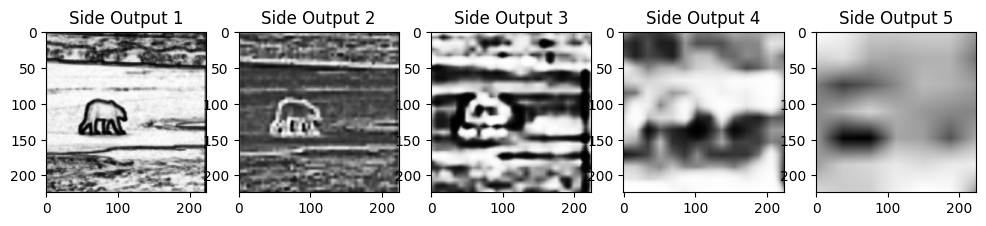

Learned Fusion Weights: [[[[-0.57745385]]

  [[ 0.4708028 ]]

  [[ 0.19771624]]

  [[-0.367891  ]]

  [[-0.32948852]]]]


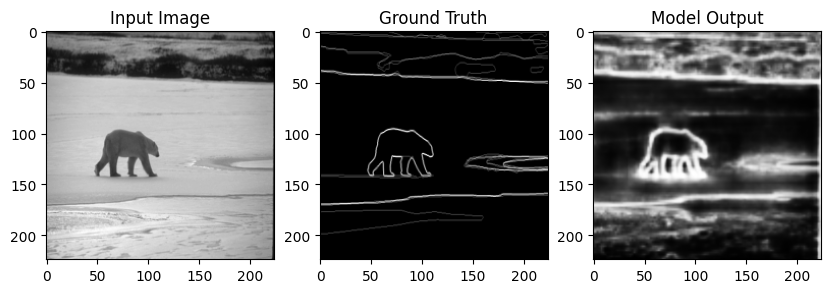

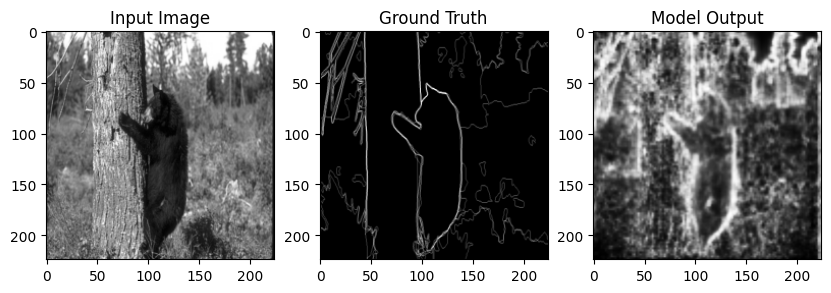

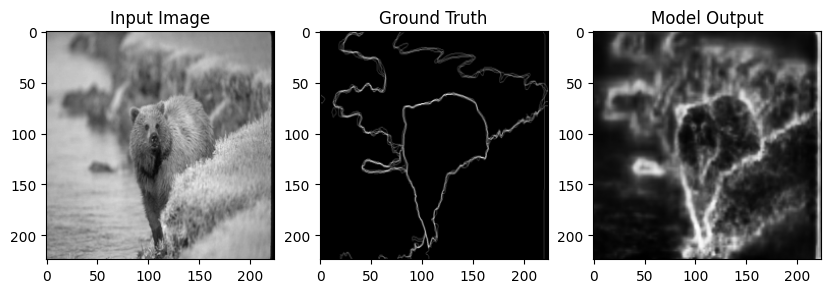

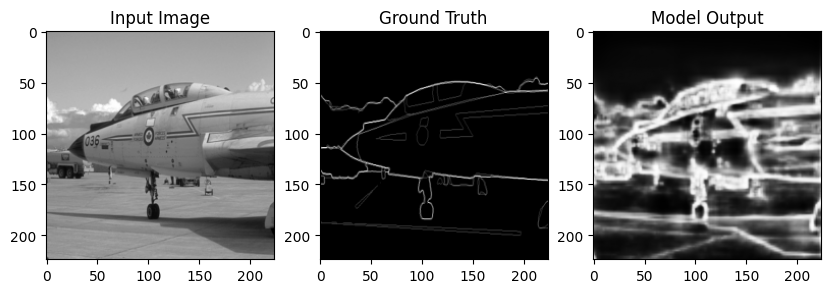

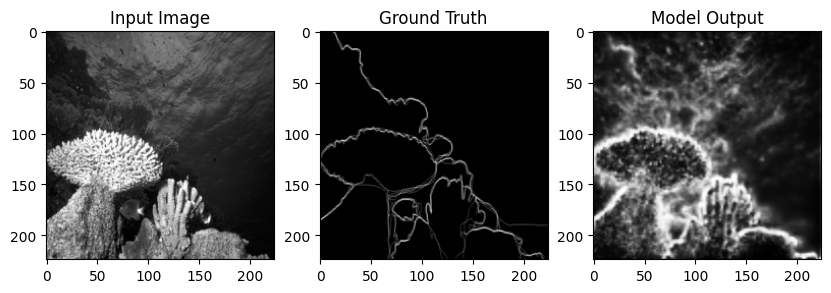

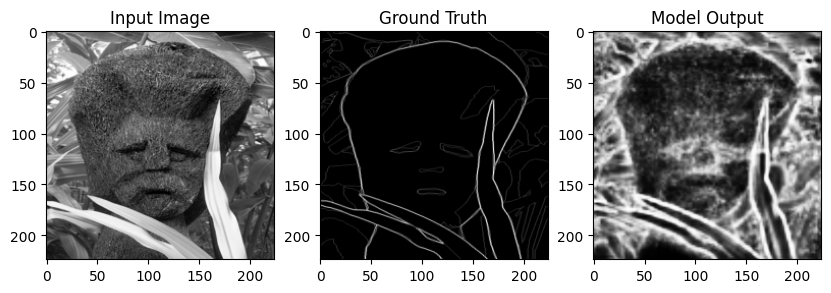

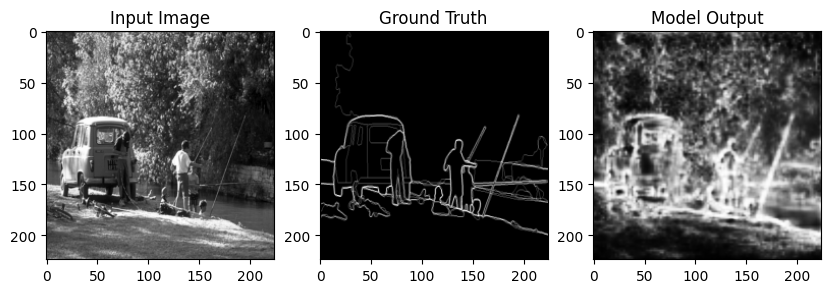

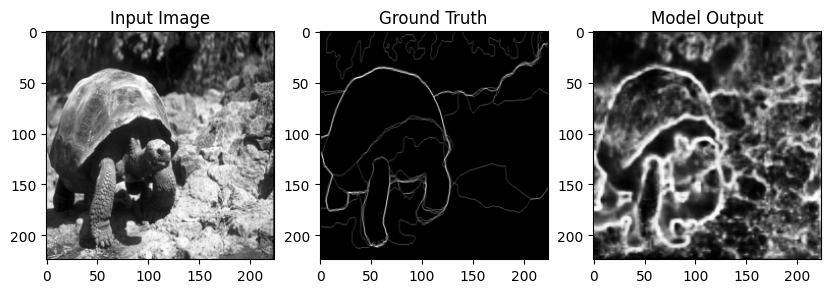

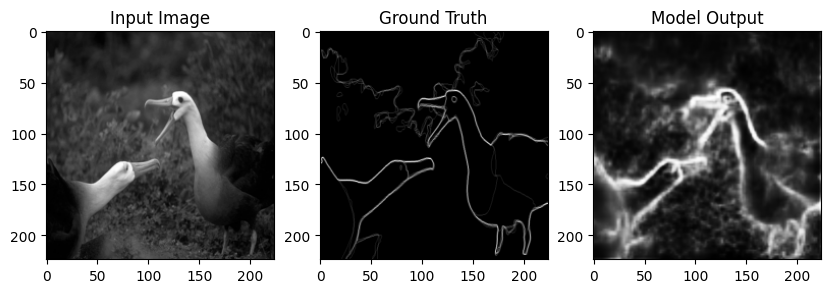

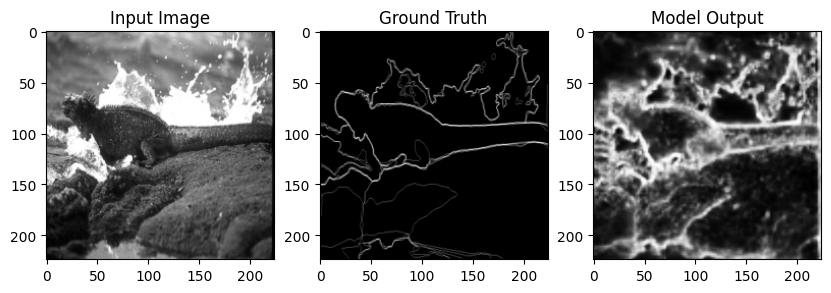

In [ ]:

# Plot Side Outputs & Fusion Weights
def plot_side_outputs_and_weights(model, image):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        side_outputs = model(image)
        plt.figure(figsize=(12, 3))
        for i, side_output in enumerate(side_outputs[:-1]):  # Skip final fused output
            plt.subplot(1, len(side_outputs) - 1, i + 1)
            plt.imshow(side_output.cpu().squeeze().numpy(), cmap='gray')
            plt.title(f'Side Output {i+1}')
        plt.show()
        print("Learned Fusion Weights:", model.weighted_fusion.weight.cpu().detach().numpy())

# Select a sample image from test set
def denormalize_image(image):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)  # Shape (C, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    if isinstance(image, np.ndarray):  # Convert to tensor if needed
        image = torch.tensor(image)
    image = image * std + mean  # Undo normalization
    image = image.clamp(0, 1)  # Ensure values are in [0,1]
    return image.numpy()  # Convert back to NumPy


def visualize_results(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        for i, (image, gt) in enumerate(test_loader):
            if i >= 10:
                break
            image, gt = image.to(device), gt.to(device)
            outputs = model(image)
            output = outputs[-1].cpu().squeeze().numpy()
            gt = gt.cpu().squeeze().numpy()
            image = image.cpu().squeeze().numpy()
            # Convert (C, H, W) -> Grayscale (H, W) using simple averaging
            image_gray = image.mean(axis=0)
            plt.figure(figsize=(10, 3))
            plt.subplot(1, 3, 1)
            plt.imshow(image_gray, cmap='gray')
            plt.title('Input Image')
            plt.subplot(1, 3, 2)
            plt.imshow(gt, cmap='gray')
            plt.title('Ground Truth')
            plt.subplot(1, 3, 3)
            plt.imshow(output, cmap='gray')
            plt.title('Model Output')
            plt.show()

if __name__ =="__main__":
  sample_image, _ = next(iter(test_loader))
  plot_side_outputs_and_weights(model, sample_image)
  visualize_results(model, test_loader, device)